In [89]:

import tensorflow
tensorflow.test.gpu_device_name()

'/device:GPU:0'

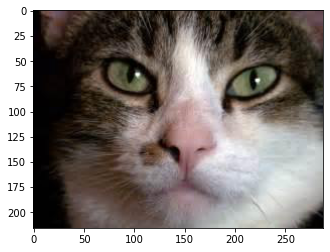

In [90]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/kaggle/input/animalsdataset/dataset/test/cat/1006.jpeg', 'r')


imshow(np.asarray(pil_im))

In [91]:

from tensorflow.keras import backend as K
from time import time

# DATA SOURCE --------------------------------------------------

train_data_dir = '/kaggle/input/animalsdataset/dataset/training'
validation_data_dir = '/kaggle/input/animalsdataset/dataset/validation'
test_data_dir = '/kaggle/input/animalsdataset/dataset/test'
image_size = (150, 150)
batch_size = 256

In [92]:
train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    #validation_split=0.2,
    #subset="training",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
validation_ds = validation_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Found 21068 files belonging to 10 classes.
Found 6634 files belonging to 10 classes.
Found 3418 files belonging to 10 classes.


# **Image Augmentation**

In [93]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1
)

validation_datagen = ImageDataGenerator(
        rescale=1./255
)


train_ds_augmentation = train_datagen.flow_from_directory(
    train_data_dir,
    #validation_split=0.2,
    subset="training",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_ds_augmentation = validation_datagen.flow_from_directory(
    validation_data_dir,
    #validation_split=0.2,
    subset="validation",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)



Found 21068 images belonging to 10 classes.
Found 0 images belonging to 10 classes.



# **The Model**

In [94]:
def build_model(hp):
    model = Sequential()

    # Escalado de las imágenes (normalización entre 0 y 1)
    model.add(Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)))

    # Primera capa convolucional
    model.add(Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Segunda capa convolucional
    model.add(Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Aplanado de la salida
    model.add(Flatten())

    # Capa densa oculta
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))

    # Dropout
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Capa de salida
    model.add(Dense(10, activation='softmax'))  # Cambia según el número de clases

    # Compilación
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Crear el tuner
tuner = kt.RandomSearch(
    hypermodel=build_model,  # La función que define el modelo
    objective='val_accuracy',  # Objetivo a optimizar
    max_trials=10,  # Número de combinaciones a probar
    executions_per_trial=1,  # Ejecuciones por combinación de hiperparámetros
    directory='tuner_results',  # Carpeta donde se guardan los resultados
    project_name='chess_tuning'  # Nombre del proyecto
)

# Realizar la búsqueda de hiperparámetros
tuner.search(
    train_ds,  # Dataset de entrenamiento
    validation_data=validation_ds,  # Dataset de validación
    epochs=10,  # Número de épocas por prueba
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]  # Early stopping opcional
)

# Obtener el mejor conjunto de hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:", best_hps.values)

# Construir el modelo con los mejores hiperparámetros
model = tuner.hypermodel.build(best_hps)

# Resumen del modelo
model.summary()

# Entrenar el modelo con los mejores hiperparámetros
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Trial 11 Complete [00h 03m 53s]
val_accuracy: 0.7952969670295715

Best val_accuracy So Far: 0.7952969670295715
Total elapsed time: 00h 44m 55s
Mejores hiperparámetros encontrados: {'filters_1': 64, 'kernel_size_1': 3, 'filters_2': 128, 'kernel_size_2': 5, 'dense_units': 192, 'dropout_rate': 0.30000000000000004, 'optimizer': 'rmsprop'}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 70, 128)       204928    
_______________________________________________

Es importante añadir que a pesar de solo conseguir un val_accuracy de 0.7855 este número es perfectamente aceptable considerando que solo ha necesitado 10 épocas para conseguir este resultado, mientras que nuestra versión necesitó alrededor de 50 épocas.

In [95]:
# SAVING --------------------------------------------------

model.save("mimodelo.h5")

#  **Evaluación de resultados**

              precision    recall  f1-score   support

           0     0.8517    0.9373    0.8925       766
           1     0.8716    0.8497    0.8605       599
           2     0.8197    0.9320    0.8722      1117
           3     0.8278    0.8936    0.8594       667
           4     0.6631    0.8827    0.7573       972
           5     0.6327    0.4291    0.5113       289
           6     0.7283    0.5935    0.6540       524
           7     0.6777    0.4505    0.5413       364
           8     0.8627    0.7759    0.8170       964
           9     0.7435    0.3817    0.5044       372

    accuracy                         0.7855      6634
   macro avg     0.7679    0.7126    0.7270      6634
weighted avg     0.7848    0.7855    0.7756      6634



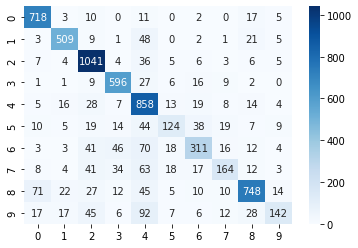

In [96]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in validation_ds], axis=1)

labels = np.argmax(results[0], axis=1)
predictions = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

#disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
#disp.plot()

print(classification_report(labels, predictions, digits = 4))

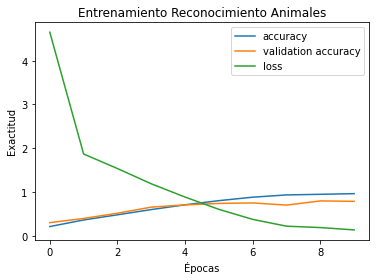

In [97]:
from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['loss'], label='loss')

plt.title('Entrenamiento Reconocimiento Animales')

plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend(loc="upper right")

plt.show()

(150, 150, 3)
El vector de salida obtenido:  [[2.0637049e-07 9.9683315e-01 4.7837921e-07 1.8942985e-05 1.3080487e-03
  8.6075413e-09 2.9514249e-09 5.3423378e-07 1.8386930e-03 3.2909341e-08]]
La etiqueta de salida predicha es  1
Ahora dicho con texto: La etiqueta de salida predicha es  cat


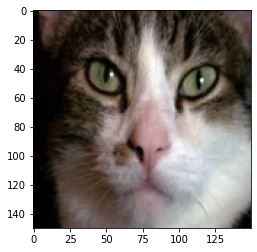

In [98]:
# PRODUCTION ----------------------------------------------

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import tensorflow.keras

# LOADING --------------------------------------------------
#model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
%matplotlib inline

pil_im = Image.open('/kaggle/input/animalsdataset/dataset/test/cat/1006.jpeg', 'r')
im = np.asarray(pil_im.resize((150, 150)))
imshow(im)
print(im.shape) # La imagen es un array de dimensión: 150x150x3

# El método `predict` hace la predicción de un lote de entradas, no solo una. 
# En el caso de que tengamos solo una entrada deberemos añadirle una dimensión más 
# al array numpy para que la entrada tenga la dimensión: 1x150x150x3

im = im.reshape(1,150,150,3)


print('El vector de salida obtenido: ', model.predict(im))
print('La etiqueta de salida predicha es ', np.argmax(model.predict(im)))
print('Ahora dicho con texto: La etiqueta de salida predicha es ', etiquetas[np.argmax(model.predict(im))])






In [99]:
# PRODUCTION ----------------------------------------------

#from matplotlib.pyplot import imshow
import numpy as np
#from PIL import Image
import tensorflow.keras

# SAVING --------------------------------------------------
#model.save_model("mimodelo.h5")


# LOADING --------------------------------------------------
#model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
%matplotlib inline
print("ETIQUETA PREDICHA -> ETIQUETA REAL")
for minilote in test_ds:
    prediccion_minilote = model.predict(minilote[0].numpy())
    etiqueta_real_minilote = minilote[1].numpy()
    for y_predicha, y_real in zip(np.round(prediccion_minilote,3), etiqueta_real_minilote):
        if np.argmax(y_predicha) == np.argmax(y_real):
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)])
        else:
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)], "✘")

ETIQUETA PREDICHA -> ETIQUETA REAL
chicken -> dog ✘
chicken -> cat ✘
cat -> cat
dog -> chicken ✘
sheep -> sheep
dog -> dog
cow -> cow
butterfly -> spider ✘
cat -> cat
chicken -> chicken
butterfly -> butterfly
chicken -> cat ✘
elephant -> elephant
chicken -> chicken
butterfly -> butterfly
spider -> spider
cat -> spider ✘
chicken -> chicken
dog -> spider ✘
chicken -> sheep ✘
dog -> squirrel ✘
horse -> horse
squirrel -> squirrel
chicken -> horse ✘
cat -> cat
chicken -> chicken
chicken -> chicken
dog -> dog
chicken -> chicken
chicken -> dog ✘
cow -> cow
dog -> horse ✘
spider -> spider
chicken -> chicken
butterfly -> butterfly
butterfly -> butterfly
spider -> spider
spider -> spider
chicken -> chicken
dog -> cat ✘
chicken -> chicken
chicken -> chicken
horse -> elephant ✘
dog -> horse ✘
chicken -> chicken
horse -> horse
spider -> spider
dog -> sheep ✘
chicken -> chicken
chicken -> chicken
dog -> dog
butterfly -> butterfly
dog -> dog
dog -> squirrel ✘
spider -> spider
cat -> cat
chicken -> sq